In [7]:
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
# read videos
import pylab          # play video
from os import listdir
import cv2
# others
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
# SINDy
import sys
sys.path.append("src")
import sindy_utils as sindy
import numpy as np


### Functions

In [2]:
# print progress, possibly faster than progress bar
def printProgress(epoch, batch_id, accuracy, loss):
    """
    print progress of the training
    epoch:
    batch_id: current batch_id
    accuracy:
    loss:
    
    """
    progress = '='* int((10. * (batch_id+1) / len(train_data)))
    progress += '>'
    if batch_id == 0:
        print('Train Epoche {}: {}% [{}]\t accuracy: {:.6f}, loss: {:.6f}'.format(
            epoch+1, int(100. * (batch_id+1) / len(train_data)),progress, accuracy, loss.item()), end='')
    else:
        print('\rTrain Epoche {}: {}% [{}]\t accuracy: {:.6f}, loss: {:.6f}'.format(
            epoch+1, int(100. * (batch_id+1) / len(train_data)),progress, accuracy, loss.item()), end='', flush = True)
        

def calculateLoss(network, params):
    """
    calculate the loss of autoencoder and SINDy combined. loss function of:
    
     O \   _________           ________  /  O
     .    |         | \  O  / |        |    .
     . -  | phi'(x) | -  O  - | phi(z) | -  .
     .    |_________| /  O  \ |________|    .
     O /                                 \  O
    x(t)                z(t)               xa(t)
    
    ||x-phi(z)||_2^2 + lam1 ||dx - (zGrad phi(z)) Theta(z^T) Xi||_2^2 + lam2 ||dz - Theta(z^T) Xi||_2^2 + lam3 ||Xi||_1
        decoder      +                   SINDy in dx                  +         SINDy in dz             +   SINDy sparsity
     
    dz = xGrad phi'(x) dx = (xGrad z) dx
    
    network: data of the network
    params: hyperparameters
    
    """
    dx = network['dx']
    dx_decode = network['dx_decode']
    dz = network['dz']
    dz_predict = network['dz_predict']
    Xi_coeff = network['Xi']
    rec_loss = network['rec_loss']
    sindy_x_loss = torch.mean((dx - dx_decode)**2)
    sindy_z_loss = torch.mean((dz - dz_predict)**2)
    sparse_loss = torch.mean(torch.abs(Xi_coeff))
                              
    separate_loss = []
    separate_loss.append(rec_loss)
    separate_loss.append(sindy_x_loss)
    separate_loss.append(sindy_z_loss)
    separate_loss.append(sparse_loss)
    
    tot_loss = (params['loss_weight_decoder'] * rec_loss
                + params['loss_weight_sindy_x'] * sindy_x_loss 
                + params['loss_weight_sindy_z'] * sindy_z_loss
                + params['loss_weight_sindy_regularization'] * sparse_loss)
                                                                                        
    return tot_loss, separate_loss

# SINDy
def calculateSindy(network, params):
    z = network['z'].detach().numpy()
    dz = network['dz'].detach().numpy()
    
    network['Theta'] = torch.from_numpy(sindy.sindy_library(z, params['poly_order'], include_sine=params['include_sine']))
    network['Xi'] = torch.from_numpy(sindy.sindy_fit(network['Theta'], dz, params['sindy_threshold']))
    dz_predict = np.dot(network['Theta'],network['Xi'])
    
    return torch.from_numpy(dz_predict)

### Define model parameters

In [4]:
params = {}

params['number_epoch'] = 3                               # number of epochs
params['z_dim'] = 10                                     # number of coordinates for SINDy
params['batch_size'] = 64                                # batch size

# loss function weighting
params['loss_weight_decoder'] = 1.0
params['loss_weight_sindy_x'] = 1e-4
params['loss_weight_sindy_z'] = 0.0
params['loss_weight_sindy_regularization'] = 1e-5

# SINDy parameters
params['sindy_threshold'] = 0.1 
params['poly_order'] = 2
params['include_sine'] = False

### Data processing

In [9]:
# read the videos in random order (evtl. outsource to a .py document)
file_names = []
for f in listdir('../../Videos/train/'):
    file_names.append(f)

random.shuffle(file_names)

# define transform to tensor and resize to 1080x1920
normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])    # normalize around mean with sigma (std)
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((1080, 1920))])

# read data to list and transform to tensor
train_data_tmp = []
train_data = []
train_idxOfNewVideo = []
count = 0
for f in file_names:
    if count == 1:
        break
    count += 1
    vidcap = cv2.VideoCapture('../../Videos/train/' + f)
    success,imgR = vidcap.read()
    print('Read:',f)
    while success:
        imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)
        imgR_tensor = transform(imgR)
        train_data_tmp.append(imgR_tensor)
        success,imgR = vidcap.read()
        if len(train_data_tmp) >= params['batch_size']:
            train_data.append(torch.stack(train_data_tmp))
            train_data_tmp = []
    train_idxOfNewVideo.append(len(train_data))
    print(len(train_data), len(train_data[0]), len(train_data[0][0]), len(train_data[0][0][0]), len(train_data[0][0][0]))


Read: St_Fabio2.MP4
4 64 3 1080 1080


3 64 3 1080 1080
tensor(0.) tensor(1.)
torch.Size([1920, 1080, 3, 64])
3 64 3 1080 1080


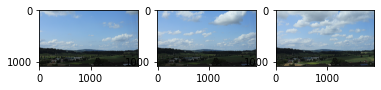

In [6]:
print(len(train_data), len(train_data[0]), len(train_data[0][0]), len(train_data[0][0][0]), len(train_data[0][0][0]))
print(torch.min(train_data[0]), torch.max(train_data[0]))

print(train_data[0].permute(3,2,1,0).size())
print(len(train_data), len(train_data[0]), len(train_data[0][0]), len(train_data[0][0][0]), len(train_data[0][0][0]))


# plot first frame per batch
for i in range(len(train_data)):
    if i%3 == 0:
        plt.figure()
    imgP = train_data[i][0].permute(1,2,0).detach().numpy()
    plt.subplot(1,3, i%3 + 1)
    plt.imshow(imgP)

               

### SINDy autoencoder

In [ ]:
# load model
if os.path.isfile('results/Autoencoder_3epoch_lossAe_v1.pt'):
    net_load = torch.load('results/Autoencoder_3epoch_lossAe_v1.pt')
    print('loaded previos model...')
    
# save network data
network = {}
    
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()               
        # encoder: N, 3, 1080, 1920
        self.conv1_e = nn.Conv2d(3, 16, 5, stride=2, padding=1) # -> N, 16, 539, 959
        self.conv2_e = nn.Conv2d(16, 32, 5, stride=2, padding=1) # -> N, 32, 269, 479
        self.conv3_e = nn.Conv2d(32, 64, 10, stride=4, padding=2) # -> N, 64, 66, 119
        self.conv4_e = nn.Conv2d(64, 128, 9, stride=2, padding=1) # -> N, 128, 30, 57
        self.conv5_e = nn.Conv2d(128, 32, 30) # -> N, 1, 1, 28
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(32*28,params['z_dim'])
        
        # decoder
        self.fc2 = nn.Linear(params['z_dim'], 32*28)
        self.convT1_d = nn.ConvTranspose2d(32, 128, 30) # -> N, 128, 30, 57
        self.convT2_d = nn.ConvTranspose2d(128, 64, 9, stride=2, padding=1, output_padding=(1,0)) # N, 64, 66, 119 (N,64,65,118 without output_padding)
        self.convT3_d = nn.ConvTranspose2d(64, 32, 10, stride=4, padding=2, output_padding=(3,1)) # N, 32, 269, 479
        self.convT4_d = nn.ConvTranspose2d(32, 16, 5, stride=2, padding=1, output_padding=(0,0)) # N, 16, 539, 959
        self.convT5_d = nn.ConvTranspose2d(16, 3, 5, stride=2, padding=1, output_padding=(1,1)) # N, 3, 1080, 1920
        
        # Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
        # Input [-1, +1] -> use nn.Tanh    

    def forward(self, x):
        #print(x.size())
        encoded = F.relu(self.conv1_e(x))
        encoded = F.relu(self.conv2_e(encoded))
        encoded = F.relu(self.conv3_e(encoded))
        encoded = F.relu(self.conv4_e(encoded))
        encoded = F.relu(self.conv5_e(encoded))
        #print(encoded.size())
        encoded = encoded.view(-1,32*28)
        #encoded = self.dropout(encoded)
        encoded = self.fc1(encoded)

        
        decoded = self.fc2(encoded)
        decoded = decoded.view(-1,32,1,28)
        decoded = F.relu(self.convT1_d(decoded))
        decoded = F.relu(self.convT2_d(decoded))
        decoded = F.relu(self.convT3_d(decoded))
        decoded = F.relu(self.convT4_d(decoded))
        decoded = torch.sigmoid(self.convT5_d(decoded))
        #print(decoded.size())
        
        return encoded, decoded

if os.path.isfile('results/Autoencoder_3epoch_lossAe_v1.pt'):
    model = net_load
else:
    model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


# training
outputs = []
for epoch in range(params['number_epoch']):
    for batch_id,img in enumerate(train_data):
        encode, recon = model(img)                 # encoded, reconstruction
        # dx, dz is from current batch_id, x, z is from previous batch_id
        if batch_id == 0:
            network['x'] = img
            network['z'] = encode
            #network['x_decode'] = 0
            network['dx'] = img
            network['dz'] = encode
            network['dx_decode'] = recon
        else:
            network['x'] = network['dx']
            network['z'] = network['dz']
            #network['x_decode'] = network['dx_decode']
            network['dx'] = img
            network['dz'] = encode
            network['dx_decode'] = recon
        
        network['rec_loss'] = criterion(recon, img)
        
        # calculate SINDy
        if batch_id >= 1:
            network['dz_predict'] = calculateSindy(network, params)
        
        if batch_id == 0:
            total_loss = network['rec_loss']       
        else: 
            total_loss, categorie_loss = calculateLoss(network, params)       # total loss with SINDy
        
        # loss got bigger, include sindy in optimization (here it's a bad mix)
        optimizer.zero_grad()
        network['rec_loss'].backward()
        optimizer.step()
        
        accuracy = 0
        printProgress(epoch, batch_id, accuracy, total_loss)
        #if batch_id == 2:
        #    break
    print('\n')
    outputs.append((epoch, img, recon))
    



Train Epoche 1: 100% [==========>]	 accuracy: 0.000000, loss: 0.347249

Train Epoche 2: 100% [==========>]	 accuracy: 0.000000, loss: 3.351285

Train Epoche 3: 25% [==>]	 accuracy: 0.000000, loss: 0.036148

In [ ]:
# SINDy prediction --> split up model that I can plug in z


In [18]:
# example prints
torch.save(model, 'results/Autoencoder_3epoch_lossAe_v1.pt')


torch.Size([64, 66]) torch.Size([66, 10])
reconstruction loss tensor(0.0394, grad_fn=<MseLossBackward0>) 
 sindy x loss tensor(0.0394, grad_fn=<MeanBackward0>) 
 sindy z loss tensor(2.3191e-21, dtype=torch.float64, grad_fn=<MeanBackward0>) 
 Xi sparsity loss tensor(243.5218, dtype=torch.float64)
tensor(0.0394, grad_fn=<MseLossBackward0>)


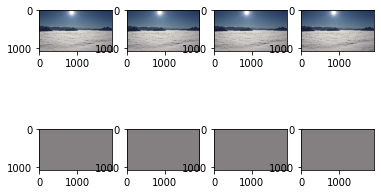

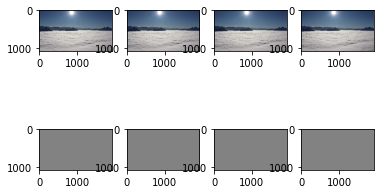

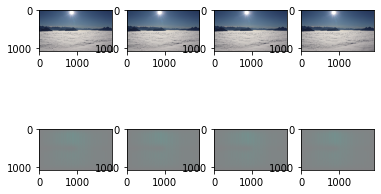

In [24]:
# plots
print(network['Theta'].shape, network['Xi'].shape)
#print(network['Xi'])

print('reconstruction loss', categorie_loss[0],'\n sindy x loss', categorie_loss[1], 
      '\n sindy z loss', categorie_loss[2], '\n Xi sparsity loss', categorie_loss[3])
print(network['rec_loss'])

for i in range(0, params['number_epoch']):
    plt.figure()
    realImg = outputs[i][1].permute(0,2,3,1).detach().numpy()
    reconImg = outputs[i][2].permute(0,2,3,1).detach().numpy()
    for i, item in enumerate(realImg):
        if i >=4: break
        plt.subplot(2,4,i+1)
        plt.imshow(item)
    for i, item in enumerate(reconImg):
        if i >=4: break
        plt.subplot(2,4,4+i+1)
        plt.imshow(item)    
